Code adapted from here: https://github.com/marcoancona/TorchPruner

Shapley Value as Principled Metric for Structured Network Pruning (2020) https://doi.org/10.48550/arxiv.2006.01795

### Pre-requisites

In [42]:
import os
import time
import logging
import math
import itertools
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
from abc import ABC, abstractmethod
from torch.nn.modules.batchnorm import _BatchNorm
from torch.nn.modules.activation import ReLU, ReLU6, RReLU, LeakyReLU, Sigmoid, Softplus, Tanh
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.dropout import _DropoutNd

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

### Config

In [43]:
class CONFIG:
    SEED = 1
    LEARNING_RATE = 0.001
    BATCH_SIZE = 128
    NUM_EPOCHS = 1000
    NUM_FEATURES = 32*32
    NUM_CLASSES = 10
    MIN_DELTA = 0.01
    VAL_SPLIT = 1000
    PATIENCE = 10
    GRAYSCALE = True
    SHAPLEY_N = 1000
    CRITERIA = 0.0
    if torch.cuda.is_available(): 
        DEVICE = "cuda:0"
    else:
        DEVICE = "cpu"

In [44]:
resize_transform = transforms.Compose([transforms.ToTensor()])

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=resize_transform,
                               download=True)

validation_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=resize_transform, 
                              download=True)

validation_dataset = torch.utils.data.Subset(validation_dataset, range(0, 1000))

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=CONFIG.BATCH_SIZE, 
                          shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset, 
                         batch_size=1000, 
                         shuffle=False)
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
device = torch.device(CONFIG.DEVICE)

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [45]:
class LeNet1(nn.Module):
    
    def __init__(self):
        super(LeNet1, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.conv2 = nn.Conv2d(4, 12, 5)
        self.fc = nn.Linear(12*4*4, CONFIG.NUM_CLASSES)
    
    def forward(self, x):
        x = F.avg_pool2d(F.tanh(self.conv1(x)), (2,2)) # Conv1, Tanh activation, max pooling
        x = F.avg_pool2d(F.tanh(self.conv2(x)), (2,2)) # Conv2, Tanh activation, max pooling
        x = torch.flatten(x, 1)                        # convert input into 1D
        logits = self.fc(x)
        return logits

In [46]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        probas = F.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [47]:
def validate_model(model, test_loader, device):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        for images, labels in test_loader:


            images = images.to(device)
            labels = labels.to(device)
            model.eval()
    
            logits = model(images)
            probas = F.softmax(logits, dim=1)
            _, y_pred = torch.max(logits, 1)

            J_val = F.cross_entropy(logits, labels)

            running_loss_val += J_val.item() * labels.size(0)
            total += labels.size(0)

            # Total number of correct predictions
            correct += (y_pred == labels).sum()

    return (running_loss_val, correct, total)

### Initial Model Training

In [48]:
model = LeNet1()
model.to(CONFIG.DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
start_time = time.time()

best_loss = None
current_patience = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    
    if current_patience >= CONFIG.PATIENCE:
        print("\n'Early Stopping' called!\n")
        break
        
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(CONFIG.DEVICE)
        targets = targets.to(CONFIG.DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        probas = F.softmax(logits, dim=1)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
    running_loss_val, val_correct, val_total = validate_model(model, validation_loader, device)
    val_cost_epoch = running_loss_val / len(validation_dataset)
    print ('VALIDATION: Epoch: %03d/%03d | LOSS: %.4f | ACCURACY: %.4f'
       %(epoch+1, CONFIG.NUM_EPOCHS, val_cost_epoch, 
         (float(val_correct)/val_total)))
    print(f'PATIENCE: {current_patience}/{CONFIG.PATIENCE}')
    if best_loss is None:
        best_loss = val_cost_epoch    
    print("Best Loss: %.4f, Current Loss: %.4f" % (best_loss, val_cost_epoch))
    if (val_cost_epoch < best_loss) and np.abs(val_cost_epoch - best_loss) >= CONFIG.MIN_DELTA:
        best_loss = val_cost_epoch
        current_patience = 0
        print(f"Saving model with lowest val_loss = {val_cost_epoch:.4f}\n")
        torch.save(model, "LeNet-1_Trained.pt")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        current_patience += 1  # number of epochs without any improvement

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, CONFIG.NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=CONFIG.DEVICE)))
        
    print('Time elapsed: %.2f min\n' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


VALIDATION: Epoch: 001/1000 | LOSS: 0.0661 | ACCURACY: 0.9840
PATIENCE: 0/10
Best Loss: 0.0661, Current Loss: 0.0661
Epoch: 001/1000 | Train: 97.363%
Time elapsed: 0.20 min

VALIDATION: Epoch: 002/1000 | LOSS: 0.0535 | ACCURACY: 0.9790
PATIENCE: 1/10
Best Loss: 0.0661, Current Loss: 0.0535
Saving model with lowest val_loss = 0.0535

Epoch: 002/1000 | Train: 97.813%
Time elapsed: 0.39 min

VALIDATION: Epoch: 003/1000 | LOSS: 0.0610 | ACCURACY: 0.9810
PATIENCE: 0/10
Best Loss: 0.0535, Current Loss: 0.0610
Epoch: 003/1000 | Train: 98.303%
Time elapsed: 0.60 min

VALIDATION: Epoch: 004/1000 | LOSS: 0.0496 | ACCURACY: 0.9850
PATIENCE: 1/10
Best Loss: 0.0535, Current Loss: 0.0496
Epoch: 004/1000 | Train: 98.532%
Time elapsed: 0.80 min

VALIDATION: Epoch: 005/1000 | LOSS: 0.0723 | ACCURACY: 0.9770
PATIENCE: 2/10
Best Loss: 0.0535, Current Loss: 0.0723
Epoch: 005/1000 | Train: 98.388%
Time elapsed: 1.00 min

VALIDATION: Epoch: 006/1000 | LOSS: 0.0674 | ACCURACY: 0.9780
PATIENCE: 3/10
Best Loss

## Visualizing the feature maps

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


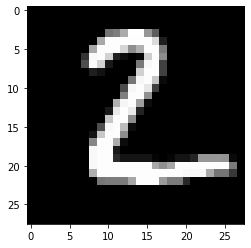

In [49]:
resize_transform = transforms.Compose([transforms.ToTensor()])

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=resize_transform,
                               download=True)

validation_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=resize_transform, 
                              download=True)

validation_dataset = torch.utils.data.Subset(validation_dataset, range(0, 1000))

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=CONFIG.BATCH_SIZE, 
                          shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset, 
                         batch_size=1000, 
                         shuffle=False)
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
device = torch.device(CONFIG.DEVICE)

iterator = iter(validation_loader)
images, labels = iterator.next()
image_set = [images[3], images[2], images[1], images[18], images[4], images[23], images[11], images[17], images[-2], images[-1]]
plt.imshow(np.transpose(image_set[2].cpu().numpy(), (1, 2, 0)), cmap = 'gray')

In [50]:
model = torch.load('../input/lenet1-9842/LeNet-1_Trained9842.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [51]:
def get_modules_individual(model):
    model_weights =[]
    conv_layers = []
    # traverse through each sequential layer
    for layer in model.children():
        # traverse through each module in sequential layer
        if type(layer) == nn.Conv2d:
            model_weights.append(layer.weight)
            conv_layers.append(layer)
    #         weights = list(layer.parameters())[0]
    return model_weights, conv_layers

In [52]:
def get_maps(conv_layers):
    outputs = []
    names = []
    image = image_set[9]
    image = image.unsqueeze(0)
    image = image.to(device)
    for layer in conv_layers[0:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
        
    return outputs, names

In [53]:
def visualize_features_pytorch(conv_layers, outputs):
#     for image in imaget_set:
    img = image_set[9]
    img = img.unsqueeze(0)
    img = img.to(device)

    # pass the image through all the layers
    results = [conv_layers[0](img)]
    results.append(conv_layers[1](F.avg_pool2d(F.tanh(results[-1]), (2,2))))
    outputs = results

    # visualize 64 features from each layer 
    for num_layer in range(len(outputs)):
        plt.figure(figsize=(15, 30))
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.data

        for i, filter in enumerate(layer_viz):
            for j, line in enumerate(filter):
                for k, pixel in enumerate(line):
                    if pixel <= 0.0:
                        filter[j][k] = -1
            if i == 64: # we will visualize only 8x8 blocks from each layer
                break
            plt.subplot(12, 1, i + 1)
            plt.imshow(filter.cpu(), cmap='gray')
            plt.axis("off")
        print(f"Saving layer {num_layer} feature maps...")
        plt.savefig(f"./layer_{num_layer}.png")
        plt.show()
    plt.close()

Saving layer 0 feature maps...


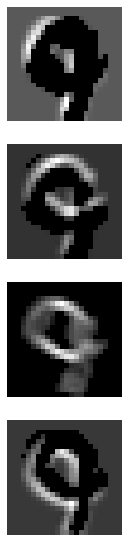

Saving layer 1 feature maps...


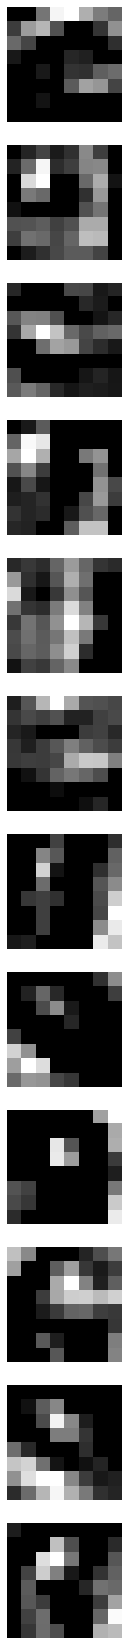

In [54]:
model_weights, conv_layers = get_modules_individual(model)
outputs, names = get_maps(conv_layers)
visualize_features_pytorch(conv_layers, outputs)

## Shapley

In [55]:
class PruningCriteria(ABC):
    
    def __init__(self, model, data_generator, criterion, device):
        self.model = model
        self.data_gen = data_generator
        self.criterion = criterion
        self.device = device
        self.deterministic = False
        self.benchmark = False
        self.bestModule = False
        self.SUPPORTED_OUT_PRUNING_MODULES = [nn.Linear, _ConvNd]
        self.count = 0

    @abstractmethod
    def run(self, module, **kwargs):
            return module
    
    def run_all_forward(self):
        """
        Run forward pass on all data in `data_gen`, returning loss for each example
        """
        self.set_deterministic()
        cumulative_loss = None
        with torch.no_grad(): # disable gradient calculation, used when no backward pass needed (speed)
            for idx, (x, y) in enumerate(self.data_gen):    # get images, labels
                x, y = x.to(self.device), y.to(self.device) # to cuda
                loss = self.criterion(self.model(x), y, reduction="none") # calculate loss based on prediction
                if cumulative_loss is None:
                    cumulative_loss = loss 
                else:
                    cumulative_loss = torch.cat((cumulative_loss, loss), 0) # concatenate tensor along y-axis
            self.restore_deterministic()
            return cumulative_loss
    
    # hooks automatically run after run_module is executed
    def _forward_hook(self):
        def _hook(module, _, output):
            module._tp_prune_dim = output.shape[1] # set the prunable dimension to the output shape
            return output.index_fill_(
                1, torch.tensor(self.mask_indices).long().to(self.device), 0.0,
            ) # fill the tesnor along x-axis along mask indices with 0.0s (nullify Neurons for Shapley)
                

        return _hook
    
    def aggregate_over_samples(self, attributions):
        return np.mean(attributions, 0)
    
    def set_deterministic(self):
        self.deterministic = torch.backends.cudnn.deterministic
        self.benchmark = torch.backends.cudnn.benchmark
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def restore_deterministic(self):
        torch.backends.cudnn.deterministic = self.deterministic
        torch.backends.cudnn.benchmark = self.benchmark

In [56]:
class HybridShapley(PruningCriteria):
    
    def __init__(self, *args, shapley_n = 5, **kwargs):
        super().__init__(*args, **kwargs)
        self.samples = shapley_n
        self.mask_indices = []
        
    def run(self, module, sv_samples=None):
        module = super().run(module) # gain access to inherited methods from class PruningCriteria
        result = self.run_module(module, self.samples)
        return result
        
    def run_module(self, module, samples):
        """
        Implementation of Shapley value.
        1. Get orignial loss (Cross-Entropy)
        2. Determine the out channels.
        3. If out channels > 6, not possible to get all permutations, switch to Monte Carlo
           Otherwise, do full Shapley
        """
        permutations = []
        with torch.no_grad():
            self.mask_indices = []
            handle = module.register_forward_hook(self._forward_hook()) # called every time after forward()
            original_loss = self.run_all_forward()                      # per sample (1000 total)
            n = module._tp_prune_dim                                    # output dimension (prunable)
            
            if n <= 6:
                permutations = permutate(n)
            sv = np.zeros((original_loss.shape[0], n))                  # set the dimensions of the SV array and fill to 0
            if not permutations == []:
                for permutation in permutations:
                    self.mask_indices = []
                    loss = original_loss.detach().clone()                # keep original loss
                    for i in permutation:
                        self.mask_indices.append(i) 
                        new_loss = self.run_all_forward() # forward pass, set i to 0
                        # calculate loss without masked index neurons
                        # NOTE:
                        # squeeze() Remove axes of length one from a.
                        # detach() Returns a new Tensor, detached from the current graph.
                        # cpu() returns a copy of the object in CPU memory
                        # numpy() returns Tensor as numpy array
                        # adjust shapley only for 1000 samples of i
                        sv[:, i] += ((new_loss - loss) / samples).squeeze().detach().cpu().numpy() 
                        loss = new_loss # old loss = new loss; calculate shapley of i+1 based on this
                print("Actual Shapley Values:")
            else:
                for j in range(samples): 
                    self.mask_indices = []
                    loss = original_loss.detach().clone() # keep original loss
                    for i in np.random.permutation(n): # randomly arrange array of n values
                        self.mask_indices.append(i) 
                        new_loss = self.run_all_forward() # forward pass, set i to 0
                        sv[:, i] += ((new_loss - loss) / samples).squeeze().detach().cpu().numpy() 
                        loss = new_loss # old loss = new loss; calculate shapley of i+1 based on this
                print("Monte Carlo Approximation of Shapley Values over %d samples:" % samples)
            sv = self.aggregate_over_samples(sv)
            handle.remove()
            print(sv)
            return sv

In [57]:
class Utility():
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    def loss(output, target, reduction="mean"):
        return F.cross_entropy(output, target, reduction=reduction)

In [58]:
class Prune:
    def __init__(self, model, input_size, device, optimizer=None):
        self.model = model
        self.device = device
        self.input_size = input_size
        self.optimizer = optimizer

    def prune_model(self, module, indices, cascading_modules=None):
        
        module_handle = module.register_forward_hook(self._nanify_hook(indices))       # called every time after forward()

        handles = []
        for next_module in cascading_modules:
            handles.append(next_module.register_forward_hook(self._detect_nan_hook())) # install listeners for each module

        self._run_forward()                                                            # run once, setting weights to NaN
        module_handle.remove()                                                         # remove hook + listeners 
        for handle in handles: 
            handle.remove()

        # Prune all CASCADING modules where nans have been detected
        for next_module in cascading_modules:
            if hasattr(next_module, "_nan_indices"):
                self.prune_module(
                    next_module, getattr(next_module, "_nan_indices"),
                    direction="in",
                    original_len=getattr(next_module, "_activation_len")
                )
                delattr(next_module, "_nan_indices")

        self.prune_module(module, indices, direction="out") 
        
    def prune_module(self, module, indices, direction="out", original_len=None):
        # Prune module parameters.
        print(f"Pruning {len(indices)} units from {module} ({direction})")
        if direction is "out":
            self.prune_parameter(module, "weight", indices, axis=0)
            self.prune_parameter(module, "bias", indices, axis=0)
        else:
            if isinstance(module, nn.Linear) or isinstance(module, _ConvNd):
                self.prune_parameter(module, "weight", indices, axis=1)

    def prune_parameter(self, module, parameter_name, indices, axis=0):
        """
        Prune a single parameter Tensor within a module
        """
        param = getattr(module, parameter_name)
        if param is not None:
            n = param.data.shape[axis]
            mask = np.ones(n, dtype=bool)                                              # create a masked matrix of ones (Boolean)
            mask[indices] = False                                                      # set neurons to mask to 0 (False)
            keep_indices = torch.tensor(np.arange(n)[mask]).to(self.device)
            param.data = param.data.index_select(axis, keep_indices)
            # If gradient is not None, we need to slice it as well
            if param.grad is not None:
                param.grad.data = param.grad.data.index_select(axis, keep_indices)


    def _nanify_hook(self, indices):
        """
        Hook to set nans of output tensor to module
        """
        def _hook(_, __, output):
            return output.index_fill_(
                1,
                torch.tensor(indices).to(self.device),
                torch.tensor(np.nan).to(self.device),
            ) # fill with nan at selected indeces along y-axis

        return _hook

    @staticmethod
    def _detect_nan_hook():
        """
        Hook to detect nans along dim 1 of input Tensor to a module
        """

        def _hook(module, input, __):
            input = input[0]
            setattr(
                module, "_activation_len", float(input.shape[1])
            ) # set attribute for prune_model() processing
            while len(input.shape) > 2:
                input = input.sum(-1)
            input = input.sum(0).flatten(0)
            indices = (
                torch.isnan(input).nonzero().flatten(0).detach().clone().cpu().numpy()
            )
            if len(indices) > 0:
                setattr(
                    module, "_nan_indices", indices
                ) # set attribute for prune_model() processing
        return _hook

    def _run_forward(self, x=None,):
        d, b = torch.backends.cudnn.deterministic, torch.backends.cudnn.benchmark
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        if x is None:
            x = (
                torch.tensor(np.random.random((2,) + self.input_size))
                .float()
                .to(self.device)
            )
        y = self.model(x)
        torch.backends.cudnn.deterministic = d
        torch.backends.cudnn.benchmark = b
        return y

In [59]:
def permutate(n):
    a = np.zeros((np.math.factorial(n), n), np.uint8)
    f = 1
    for m in range(2, n+1):
        b = a[:f, n-m+1:]      # the block of permutations of range(m-1)
        for i in range(1, m):
            a[i*f:(i+1)*f, n-m] = i
            a[i*f:(i+1)*f, n-m+1:] = b + (b >= i)
        b += 1
        f *= m
    return a

In [60]:
def test(model, device, loss, test_loader, verbose=1):
    model.eval()
    cum_test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            cum_test_loss += loss(output, target).item() * len(target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_accuracy = correct / len(test_loader.dataset)
        avg_test_loss = cum_test_loss / len(test_loader.dataset)
        return avg_test_loss, test_accuracy

In [61]:
def graph(sv, module):
    arr = np.reshape(sv, (len(sv),1))
    print(arr)
    sn.set(rc = {'figure.figsize':(16,24)})
    plt.subplot(1, 12, 1) 
    fig = sn.heatmap(arr,annot=True, fmt=".2f", square = True, vmin = CONFIG.CRITERIA, vmax = np.max(arr)) 
    plt.axis('off')
    plt.savefig(f'shapleyHeat{module}.png', bbox_inches='tight')
    plt.show()

### Run Shapley Without Fine-Tuning Until No filters left

Number of Initial Parameters: 3246
Accuracy: 0.985, Average Loss: 0.04425276070833206
Monte Carlo Approximation of Shapley Values over 50 samples:
[ 0.25927727 -0.01905385  0.25773925  0.14130283  0.17246845  0.33505342
 -0.13303057  0.34614365  0.27398307  0.19839968  0.29931008  0.19867096]
[ 0.25927727 -0.01905385  0.25773925  0.14130283  0.17246845  0.33505342
 -0.13303057  0.34614365  0.27398307  0.19839968  0.29931008  0.19867096]
[[ 0.25927727]
 [-0.01905385]
 [ 0.25773925]
 [ 0.14130283]
 [ 0.17246845]
 [ 0.33505342]
 [-0.13303057]
 [ 0.34614365]
 [ 0.27398307]
 [ 0.19839968]
 [ 0.29931008]
 [ 0.19867096]]


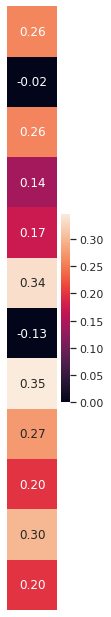

Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 2985
Time Iteration Took: 56.97890830039978 seconds
Accuracy After Iteration: 0.97	Loss: 0.0868486538529396


Number of Initial Parameters: 2985
Accuracy: 0.97, Average Loss: 0.0868486538529396
Monte Carlo Approximation of Shapley Values over 50 samples:
[ 0.22934634 -0.08724674  0.28009472  0.13863579  0.20343542  0.19515584
  0.24739569  0.31514488  0.30497067  0.27961981  0.18111593]
[ 0.22934634 -0.08724674  0.28009472  0.13863579  0.20343542  0.19515584
  0.24739569  0.31514488  0.30497067  0.27961981  0.18111593]
[[ 0.22934634]
 [-0.08724674]
 [ 0.28009472]
 [ 0.13863579]
 [ 0.20343542]
 [ 0.19515584]
 [ 0.24739569]
 [ 0.31514488]
 [ 0.30497067]
 [ 0.27961981]
 [ 0.18111593]]


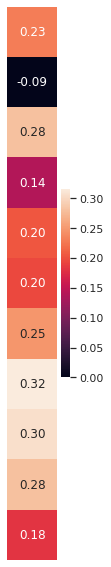

Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 2724
Time Iteration Took: 51.36908435821533 seconds
Accuracy After Iteration: 0.95	Loss: 0.14906886219978333


Number of Initial Parameters: 2724
Accuracy: 0.95, Average Loss: 0.14906886219978333
Monte Carlo Approximation of Shapley Values over 50 samples:
[0.16638391 0.26974947 0.09740098 0.40599642 0.25255646 0.16239528
 0.2851308  0.23325493 0.26710388 0.08547599]
[0.16638391 0.26974947 0.09740098 0.40599642 0.25255646 0.16239528
 0.2851308  0.23325493 0.26710388 0.08547599]
[[0.16638391]
 [0.26974947]
 [0.09740098]
 [0.40599642]
 [0.25255646]
 [0.16239528]
 [0.2851308 ]
 [0.23325493]
 [0.26710388]
 [0.08547599]]


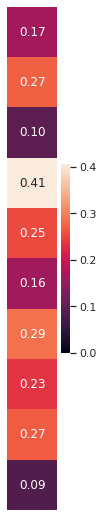

Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 2463
Time Iteration Took: 45.73805594444275 seconds
Accuracy After Iteration: 0.952	Loss: 0.1389845907688141


Number of Initial Parameters: 2463
Accuracy: 0.952, Average Loss: 0.1389845907688141
Monte Carlo Approximation of Shapley Values over 50 samples:
[0.20343831 0.25117464 0.12644291 0.37846703 0.241215   0.25568418
 0.25576844 0.21711683 0.30622506]
[0.20343831 0.25117464 0.12644291 0.37846703 0.241215   0.25568418
 0.25576844 0.21711683 0.30622506]
[[0.20343831]
 [0.25117464]
 [0.12644291]
 [0.37846703]
 [0.241215  ]
 [0.25568418]
 [0.25576844]
 [0.21711683]
 [0.30622506]]


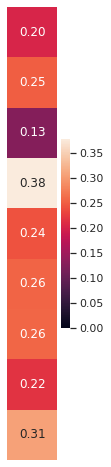

Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 2202
Time Iteration Took: 42.328585386276245 seconds
Accuracy After Iteration: 0.914	Loss: 0.22647714614868164


Number of Initial Parameters: 2202
Accuracy: 0.914, Average Loss: 0.22647714614868164
Monte Carlo Approximation of Shapley Values over 50 samples:
[0.14863058 0.3534545  0.49727793 0.27569776 0.34182161 0.30024683
 0.26833074]
[0.14863058 0.3534545  0.49727793 0.27569776 0.34182161 0.30024683
 0.26833074]
[[0.14863058]
 [0.3534545 ]
 [0.49727793]
 [0.27569776]
 [0.34182161]
 [0.30024683]
 [0.26833074]]


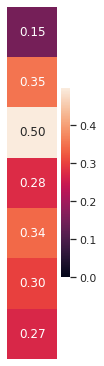

Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 1680
Time Iteration Took: 32.50648546218872 seconds
Accuracy After Iteration: 0.919	Loss: 0.2611581087112427


Number of Initial Parameters: 1680
Accuracy: 0.919, Average Loss: 0.2611581087112427


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Actual Shapley Values:
[5.70017002 5.33340148 4.67933912 6.26053499 4.29161297 4.16730943]
[5.70017002 5.33340148 4.67933912 6.26053499 4.29161297 4.16730943]
[[5.70017002]
 [5.33340148]
 [4.67933912]
 [6.26053499]
 [4.29161297]
 [4.16730943]]


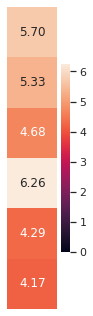

Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 1419
Time Iteration Took: 392.8504626750946 seconds
Accuracy After Iteration: 0.868	Loss: 0.3756446838378906


Number of Initial Parameters: 1419
Accuracy: 0.868, Average Loss: 0.3756446838378906
Actual Shapley Values:
[1.18855194 0.96628236 0.80873108 1.11661035 0.71711786]
[1.18855194 0.96628236 0.80873108 1.11661035 0.71711786]
[[1.18855194]
 [0.96628236]
 [0.80873108]
 [1.11661035]
 [0.71711786]]


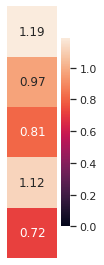

Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 1158
Time Iteration Took: 54.416486978530884 seconds
Accuracy After Iteration: 0.82	Loss: 0.5395406484603882


Number of Initial Parameters: 1158
Accuracy: 0.82, Average Loss: 0.5395406484603882
Actual Shapley Values:
[0.25502817 0.22841162 0.15692815 0.24042071]
[0.25502817 0.22841162 0.15692815 0.24042071]
[[0.25502817]
 [0.22841162]
 [0.15692815]
 [0.24042071]]


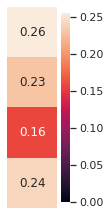

Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 897
Time Iteration Took: 8.818599462509155 seconds
Accuracy After Iteration: 0.795	Loss: 0.6582168340682983


Number of Initial Parameters: 897
Accuracy: 0.795, Average Loss: 0.6582168340682983
Actual Shapley Values:
[0.08019734 0.0533246  0.07243408]
[0.08019734 0.0533246  0.07243408]
[[0.08019734]
 [0.0533246 ]
 [0.07243408]]


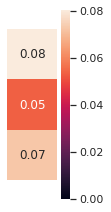

Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 636
Time Iteration Took: 1.9828565120697021 seconds
Accuracy After Iteration: 0.498	Loss: 1.3101086616516113


Number of Initial Parameters: 636
Accuracy: 0.498, Average Loss: 1.3101086616516113
Actual Shapley Values:
[0.02512335 0.017453  ]
[0.02512335 0.017453  ]
[[0.02512335]
 [0.017453  ]]


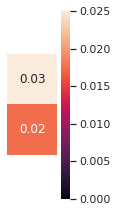

Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 375
Time Iteration Took: 0.8566429615020752 seconds
Accuracy After Iteration: 0.398	Loss: 1.6950918436050415




In [63]:
torch.manual_seed(CONFIG.SEED)
model = torch.load('/kaggle/input/lenet1-9842/LeNet-1_Trained9842.pt') 
shapley_df = pd.DataFrame(columns=['Pruned Layers', 'Accuracy', 'Loss', 'Parameters'])

for i in range(11):
    model = model.to(device)
    loss = Utility.loss
    input_size = (1, 28, 28)
    layers = []

    ACTIVATIONS = [ReLU, ReLU6, RReLU, LeakyReLU, Sigmoid, Softplus, Tanh]
    shapley = HybridShapley(model = model, data_generator = validation_loader, criterion = loss, device = device, shapley_n = CONFIG.SHAPLEY_N)
    pruner = Prune(model, input_size, device)
    count = 0
    layers = list(model.children())

    prunable_layers = [
    #         (layers[0], [layers[1]]),
        (layers[1], [layers[2]])
    ]

    initial_params = Utility.count_parameters(model)
    print("Number of Initial Parameters: " + str(initial_params))
    avg_test_loss, test_accuracy = test(model, device, loss, validation_loader)
    print(f"Accuracy: {test_accuracy}, Average Loss: {avg_test_loss}")

    for module, cascading_modules in prunable_layers[::-1]:
        # Compute Shapley Value attributions
        start = time.time()
        sv = shapley.run(module)
        print(sv)
        prune_index =  [np.argmin(sv)]
        graph(sv, module)
        if prune_index:
            pruner.prune_model(module, prune_index, cascading_modules=cascading_modules)
        print("Number of Parameters After Iteration: " + str(Utility.count_parameters(model)))
        print("Time Iteration Took: %s seconds" % (time.time() - start))
        avg_test_loss, test_accuracy = test(model, device, loss, validation_loader)
        print("Accuracy After Iteration: " + str(test_accuracy) + "\tLoss: " + str(avg_test_loss) + "\n\n")

        shapley_df = shapley_df.append({'Pruned Layers': i+1, 'Accuracy': test_accuracy, 'Loss': avg_test_loss, 'Parameters': Utility.count_parameters(model)}, ignore_index=True)
        torch.save(model, 'prunedShapley.pt')

shapley_df.to_csv('prunedShapley.csv')


### Run Random Pruning Without Fine-Tuning until no filters left

In [67]:
model = torch.load('/kaggle/input/lenet1-9842/LeNet-1_Trained9842.pt') 
model = model.to(device)
loss = Utility.loss

input_size = (1, 28, 28)
layers = []
ACTIVATIONS = [ReLU, ReLU6, RReLU, LeakyReLU, Sigmoid, Softplus, Tanh]
random_df = pd.DataFrame(columns=['Pruned Layers', 'Accuracy', 'Loss', 'Parameters'])
for i in range(11):
    pruner = Prune(model, input_size, device)
    count = 0
    layers = list(model.children())
    prunable_layers = [
#         (layers[0], [layers[1]]),
        (layers[1], [layers[2]])
    ]
    initial_params = Utility.count_parameters(model)
    print("Number of Initial Parameters: " + str(initial_params))
    avg_test_loss, test_accuracy = test(model, device, loss, validation_loader)
    print(f"Accuracy: {test_accuracy}")

    for module, cascading_modules in prunable_layers[::-1]:
        start = time.time()
        prune_index =  [random.randint(0, 11-i)]
        if prune_index:
            pruner.prune_model(module, prune_index, cascading_modules=cascading_modules)
        print("Number of Parameters After Iteration: " + str(Utility.count_parameters(model)))
        print("Time Iteration Took: %s seconds" % (time.time() - start))
        avg_test_loss, test_accuracy = test(model, device, loss, validation_loader)
        print("Accuracy After Iteration: " + str(test_accuracy)+ "\tLoss: " + str(avg_test_loss)+"\n\n")
        random_df = random_df.append({'Pruned Layers': i+1, 'Accuracy': test_accuracy, 'Loss': avg_test_loss, 'Parameters': Utility.count_parameters(model)}, ignore_index=True)
        
random_df.to_csv('prunedRandom.csv')

Number of Initial Parameters: 3246
Accuracy: 0.985
Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 2985
Time Iteration Took: 0.0012753009796142578 seconds
Accuracy After Iteration: 0.982	Loss: 0.06473509222269058


Number of Initial Parameters: 2985


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy: 0.982
Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 2724
Time Iteration Took: 0.0015475749969482422 seconds
Accuracy After Iteration: 0.946	Loss: 0.16705895960330963


Number of Initial Parameters: 2724
Accuracy: 0.946
Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 2463
Time Iteration Took: 0.0011641979217529297 seconds
Accuracy After Iteration: 0.927	Loss: 0.23655088245868683


Number of Initial Parameters: 2463
Accuracy: 0.927
Pruning 16 units from Linear(in_features=192, out_features=10, bias=True) (in)
Pruning 1 units from Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1)) (out)
Number of Parameters After Iteration: 2202
Time Iteration Took: 0.0011925697326660156 seconds
Accuracy After 